In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [22]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [23]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [40]:
class Meso4FineTune(Meso4):
    def fine_tune(self, generator, fine_tune_epochs=5):
        # Unfreeze some layers for fine-tuning
        for layer in self.model.layers:
            layer.trainable = True
        
        # Lower learning rate for fine-tuning
        optimizer = Adam(lr=self.model.optimizer.lr / 10)  # Access learning rate from Meso4 model
        self.model.compile(optimizer=optimizer,
                           loss='mean_squared_error',
                           metrics=['accuracy'])
        
        # Fine-tune the model
        self.model.fit(generator,
                       epochs=fine_tune_epochs,
                       steps_per_epoch=len(generator),
                       verbose=1)
        print("Fine-tuning completed.")


In [24]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [25]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [41]:
meso_fine_tune = Meso4FineTune()
meso_fine_tune.fine_tune(generator, fine_tune_epochs=5)  # You can adjust the number of fine-tune epochs

Epoch 1/5
7104/7104 [==============================] - 403s 56ms/step - loss: 0.1535 - accuracy: 0.8124
Epoch 2/5
7104/7104 [==============================] - 395s 56ms/step - loss: 0.0656 - accuracy: 0.9131
Epoch 3/5
7104/7104 [==============================] - 394s 55ms/step - loss: 0.0472 - accuracy: 0.9433
Epoch 4/5
7104/7104 [==============================] - 408s 57ms/step - loss: 0.0371 - accuracy: 0.9534
Epoch 5/5
7104/7104 [==============================] - 414s 58ms/step - loss: 0.0241 - accuracy: 0.9707
Fine-tuning completed.


In [26]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 7104 images belonging to 2 classes.


In [27]:
# Checking class assignment
generator.class_indices

{'DeepFake': 0, 'Real': 1}

The system cannot find the path specified.


In [29]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 7104 images belonging to 2 classes.


{'DeepFake': 0, 'Real': 1}

1/1 [==============================] - 0s 219ms/step
Predicted likelihood: 0.8426
Actual label: 1
1/1 [==============================] - 0s 52ms/step

Correct prediction: True


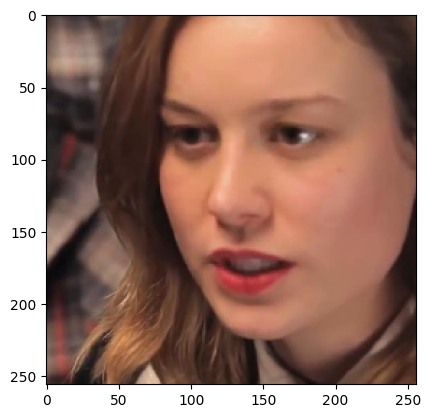

In [30]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [31]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [32]:
# Generating predictions on validation set, storing in separate lists
for i in range(1000):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    print(y)
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 100 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 58ms/step
[1.]
0  predictions completed.
1/1 [==============================] - 0s 53ms/step
[1.]
1/1 [==============================] - 0s 51ms/step
[0.]
1/1 [==============================] - 0s 62ms/step
[1.]
1/1 [==============================] - 0s 45ms/step
[0.]
1/1 [==============================] - 0s 60ms/step
[1.]
1/1 [==============================] - 0s 48ms/step
[0.]
1/1 [==============================] - 0s 49ms/step
[1.]
1/1 [==============================] - 0s 48ms/step
[1.]
1/1 [==============================] - 0s 47ms/step
[1.]
1/1 [==============================] - 0s 48ms/step
[1.]
1/1 [==============================] - 0s 53ms/step
[1.]
1/1 [==============================] - 0s 63ms/step
[1.]
1/1 [==============================] - 0s 45ms/step
[1.]
1/1 [==============================] - 0s 47ms/step
[1.]
1/1 [==============================] - 0s 46ms/step
[1.]
1/1 [==============================] - 0s 55ms/step
[1.]
1/1 [

In [33]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show
    return

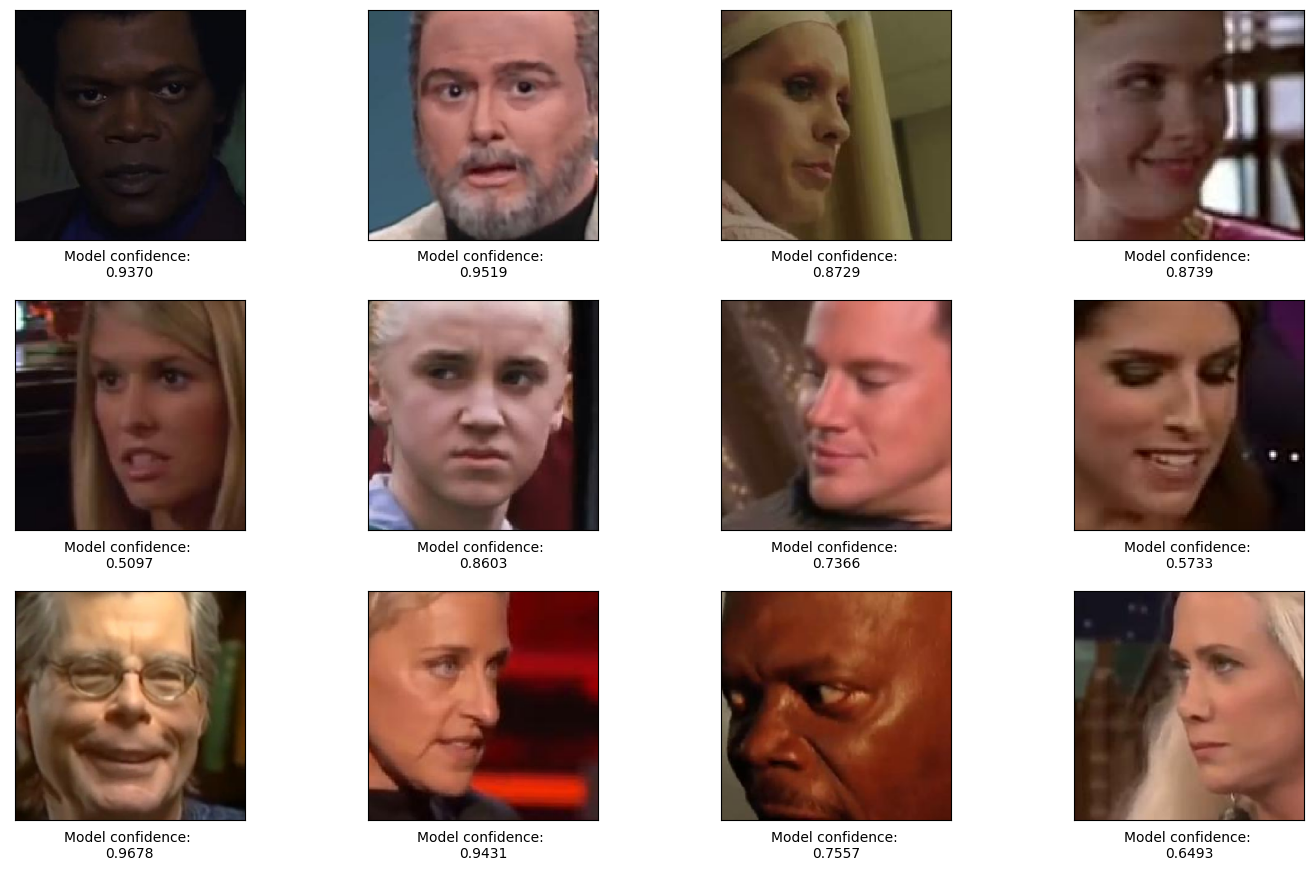

In [34]:
plotter(correct_real, correct_real_pred)

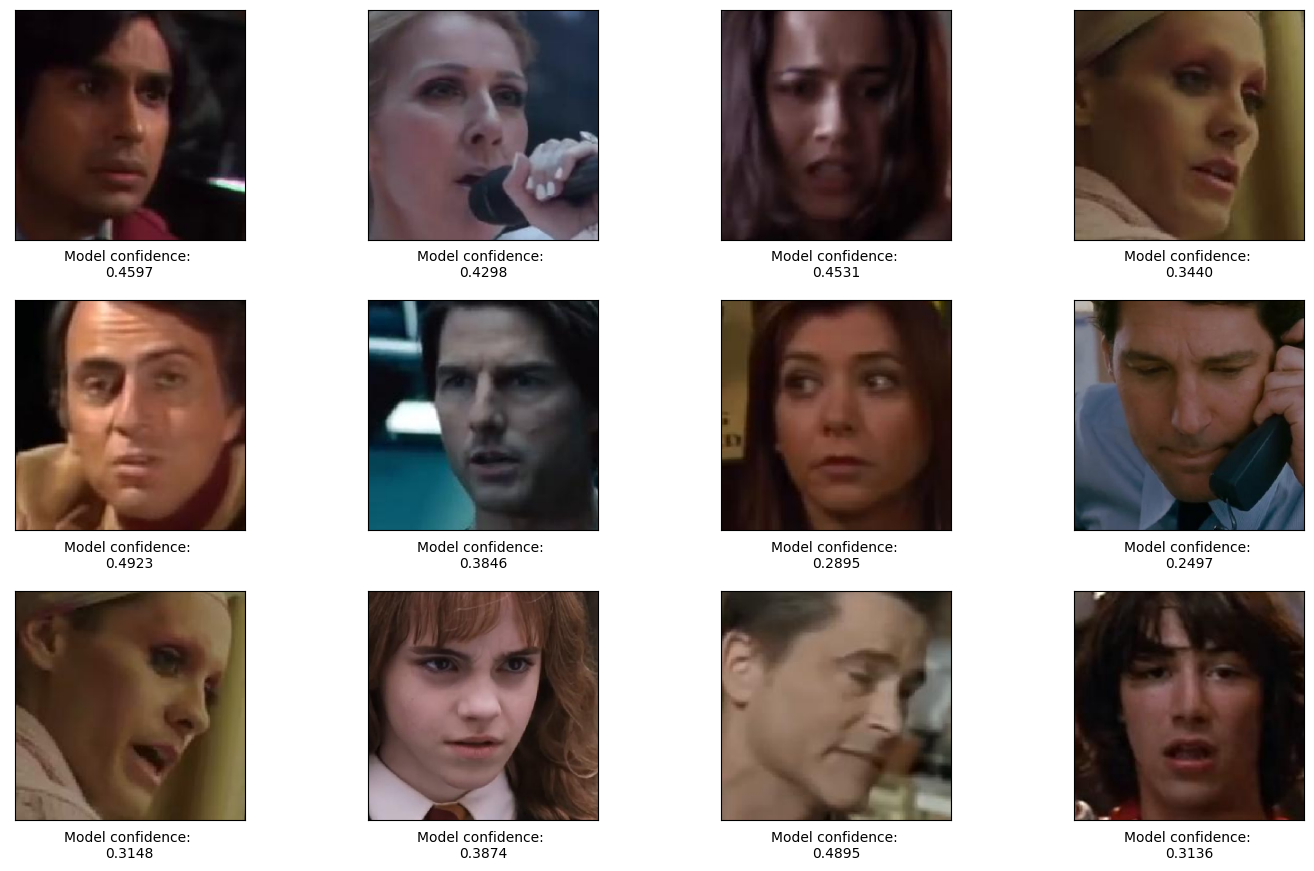

In [35]:
plotter(misclassified_real, misclassified_real_pred)